In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score
from multiprocessing.dummy import Pool
import pandas as pd


from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor, LBPDescriptor, DescriptorsTransformer
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.texture import get_glcm, lbph

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Counter
from sklearn.base import TransformerMixin, BaseEstimator

import scipy

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Loading color descriptors

In [3]:
KP_SIZE = 25
color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'YCrCb':cv2.COLOR_RGB2YCrCb}

root_path = Path().resolve()

chall1 = root_path/"data/processed/chall2/train"
mel_imgs_all = np.array(list((chall1/'mel').glob("*inpaint_0_5.png")))
bcc_imgs_all = np.array(list((chall1/'bcc').glob("*inpaint_0_5.png")))
scc_imgs_all = np.array(list((chall1/'scc').glob("*inpaint_0_5.png")))
test_imgs_train = np.concatenate([mel_imgs_all, bcc_imgs_all, scc_imgs_all])

chall1 = root_path/"data/processed/chall2/val"
mel_imgs_all = np.array(list((chall1/'mel').glob("*inpaint_0_5.png")))
bcc_imgs_all = np.array(list((chall1/'bcc').glob("*inpaint_0_5.png")))
scc_imgs_all = np.array(list((chall1/'scc').glob("*inpaint_0_5.png")))
test_imgs_val = np.concatenate([mel_imgs_all, bcc_imgs_all, scc_imgs_all])

print(f'Train images {len(test_imgs_train)}, Validation images {len(test_imgs_val)}')

Train images 5082, Validation images 1270


In [4]:
descriptors_color_train, img_classes_color_train, img_names_color_train = pd.read_pickle('descriptors_color_all_train.pkl')
descriptors_color_val, img_classes_color_val, img_names_color_val = pd.read_pickle('descriptors_color_all_val_gauss.pkl')
print(len(descriptors_color_train), len(descriptors_color_val))

5082 1270


### BoW

#### Checking optimal number of words on color

In [83]:
descriptors_color_train = np.asarray(descriptors_color_train)
descriptors_color_val = np.asarray(descriptors_color_val)
bow_words = [5, 8, 10, 20, 30, 50, 60, 70, 80, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 15000]
res = []
for nw in tqdm(bow_words):
    r = dict()
    bow_color = BagofWords(n_words=nw, n_jobs=-1, random_state=42)
    train_BoWed = bow_color.fit_transform(descriptors_color_train, img_classes_color_train) 
    val_BoWed = bow_color.transform(descriptors_color_val)

    bow_train = pd.DataFrame(train_BoWed.toarray(), columns=[f'bow_{i}' for i in range(train_BoWed.shape[1])])
    bow_val = pd.DataFrame(val_BoWed.toarray(), columns=[f'bow_{i}' for i in range(val_BoWed.shape[1])])

    bow_train['class'] = img_classes_color_train
    bow_val['class'] = img_classes_color_val

    bow_train['name'] = img_names_color_train
    bow_val['name'] = img_names_color_val


    svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
    svc.fit(bow_train.drop(['class', 'name'], axis=1), bow_train['class'])
    y_pred = svc.predict(bow_val.drop(['class', 'name'], axis=1))
    y_pred_train = svc.predict(bow_train.drop(['class', 'name'], axis=1))

    r['cf'] = confusion_matrix(bow_val['class'], y_pred)
    r['Train f1_weighted'] = f1_score(bow_train['class'], y_pred_train, average='weighted')
    r['Validation f1_weighted'] =  f1_score(bow_val['class'], y_pred, average='weighted')
    r['Train kappa'] = cohen_kappa_score(bow_train['class'], y_pred_train)
    r['Validation kappa'] =  cohen_kappa_score(bow_val['class'], y_pred)
    
    res.append(r)

100%|██████████| 7/7 [3:53:17<00:00, 1999.58s/it]


In [6]:
# rr = pd.DataFrame(res, index=bow_words)
#rr.to_csv('bow_color_numOFwords.csv')
rr = pd.read_csv('bow_color_numOFwords.csv', index_col=0)
rr

,cf,Train f1_weighted,Validation f1_weighted,Train kappa,Validation kappa
5,[[324 174 0]\n [140 538 0]\n [ 57 37 0]],0.670780,0.651905,0.424521,0.387242
8,[[349 149 0]\n [147 531 0]\n [ 55 39 0]],0.688920,0.666758,0.461281,0.417993
10,[[383 115 0]\n [172 506 0]\n [ 59 35 0]],0.702550,0.675111,0.491383,0.438900
20,[[379 119 0]\n [146 532 0]\n [ 62 32 0]],0.713621,0.691305,0.511781,0.468303
30,[[381 117 0]\n [125 553 0]\n [ 61 33 0]],0.726855,0.708114,0.536626,0.500269
50,[[394 103 1]\n [130 548 0]\n [ 57 32 5]],0.755602,0.723684,0.584986,0.522969
60,[[388 108 2]\n [121 556 1]\n [ 63 28 3]],0.758916,0.722145,0.591957,0.522069
70,[[394 104 0]\n [128 550 0]\n [ 58 35 1]],0.761965,0.717782,0.598963,0.518279
80,[[397 100 1]\n [127 551 0]\n [ 64 29 1]],0.768700,0.721454,0.611461,0.525329
100,[[399 98 1]\n [126 552 0]\n [ 63 26 5]],0.785625,0.730826,0.638138,0.536940


Text(0, 0.5, 'Kappa')

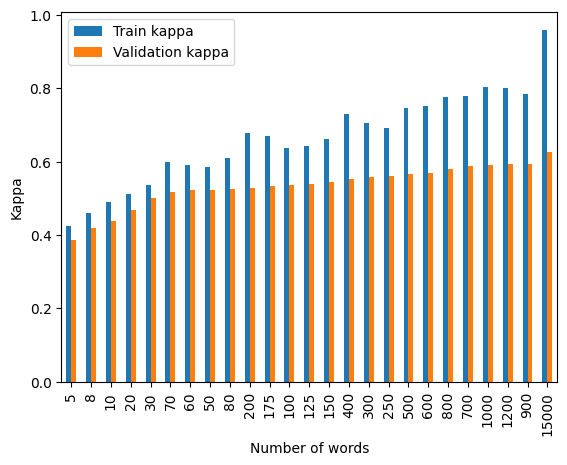

In [7]:
rr[['Train kappa', 'Validation kappa']].sort_values(['Validation kappa']).plot.bar()
plt.xlabel('Number of words')
plt.ylabel('Kappa')

### Testing color BoW

In [5]:
descriptors_color_train = np.asarray(descriptors_color_train)
descriptors_color_val = np.asarray(descriptors_color_val)


bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=42)
train_BoWed = bow_color.fit_transform(descriptors_color_train, img_classes_color_train) 
val_BoWed = bow_color.transform(descriptors_color_val)

bow_train = pd.DataFrame(train_BoWed.toarray(), columns=[f'bow_{i}' for i in range(train_BoWed.shape[1])])
bow_val = pd.DataFrame(val_BoWed.toarray(), columns=[f'bow_{i}' for i in range(val_BoWed.shape[1])])

bow_train['class'] = img_classes_color_train
bow_val['class'] = img_classes_color_val

bow_train['name'] = img_names_color_train
bow_val['name'] = img_names_color_val


svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
svc.fit(bow_train.drop(['class', 'name'], axis=1), bow_train['class'])
y_pred = svc.predict(bow_val.drop(['class', 'name'], axis=1))
y_pred_train = svc.predict(bow_train.drop(['class', 'name'], axis=1))

print(confusion_matrix(bow_val['class'], y_pred))
print('Train f1_weighted',f1_score(bow_train['class'], y_pred_train, average='weighted'))
print('Validation f1_weighted', f1_score(bow_val['class'], y_pred, average='weighted'))
print('Train kappa',cohen_kappa_score(bow_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(bow_val['class'], y_pred))

[[399  98   1]
 [126 552   0]
 [ 63  26   5]]
Train f1_weighted 0.785624708932611
Validation f1_weighted 0.7308260342898841
Train kappa 0.6381381740298608
Validation kappa 0.5369398409631391


## Extracting color features

In [6]:
def extract_color(image_path):
    cfe = ColorFeaturesExtractor(color_spaces)
    im = cv2.imread(str(image_path))
    im = im[im.shape[0]//4:im.shape[0]*3//4, im.shape[1]//4:im.shape[1]*3//4, :]

    
    mask = np.ones_like(im[:,:,0]) #cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = cfe.extract_masked(im, mask)

    return (des, img_cls, image_path.name)

colf_train = []
colc_train = []
colnam_train = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_color,
                                       test_imgs_train), total=len(test_imgs_train)):
        colf_train.append(des)
        colc_train.append(img_cls)
        colnam_train.append(img_name)

100%|██████████| 5082/5082 [00:58<00:00, 86.18it/s] 


In [7]:
colf_val = []
colc_val = []
colnam_val = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_color,
                                       test_imgs_val), total=len(test_imgs_val)):
        colf_val.append(des)
        colc_val.append(img_cls)
        colnam_val.append(img_name)

100%|██████████| 1270/1270 [00:12<00:00, 101.84it/s]


In [8]:
color_df_train = pd.DataFrame(colf_train)
color_df_train['name'] = colnam_train
color_df_train['class'] = colc_train

color_df_val = pd.DataFrame(colf_val)
color_df_val['name'] = colnam_val
color_df_val['class'] = colc_val


scaler = DescriptorsTransformer(imputation=None)
X_train = scaler.fit_transform(color_df_train.drop(['class', 'name'], axis=1))
X_test = scaler.transform(color_df_val.drop(['class', 'name'], axis=1))

svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
svc.fit(X_train, color_df_train['class'])
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(color_df_val['class'], y_pred))
print('Train f1_weighted',f1_score(color_df_train['class'], y_pred_train, average='weighted'))
print('Validation f1_weighted', f1_score(color_df_val['class'], y_pred, average='weighted'))
print('Train kappa',cohen_kappa_score(color_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(color_df_val['class'], y_pred))

[[435  61   2]
 [ 62 616   0]
 [ 57  31   6]]
Train f1_weighted 0.8190181201191215
Validation f1_weighted 0.8075351154802809
Train kappa 0.706336521578109
Validation kappa 0.6840692709452578


```
Preprocessed 

[[435  61   2]
 [ 62 616   0]
 [ 57  31   6]]
Train f1_weighted 0.8190181201191215
Validation f1_weighted 0.8075351154802809
Train kappa 0.706336521578109
Validation kappa 0.6840692709452578

```

## Extracting texture features

### GLCM

In [9]:
def extract_text(image_path):
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = glcm_features(im)

    return (des, img_cls, image_path.name)

txtf_train = []
txtcl_train = []
txtnam_train = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_text,
                                       test_imgs_train), total=len(test_imgs_train)):
        txtf_train.append(des)
        txtcl_train.append(img_cls)
        txtnam_train.append(img_name)
        
txtf_val = []
txtcl_val = []
txtnam_val = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_text,
                                       test_imgs_val), total=len(test_imgs_val)):
        txtf_val.append(des)
        txtcl_val.append(img_cls)
        txtnam_val.append(img_name)

100%|██████████| 1270/1270 [00:47<00:00, 26.51it/s]


In [10]:
# unrevelling the dataframe
txtf_exp_train = []
for i in range(len(txtf_train)):
    res = dict()
    for feat in txtf_train[i].keys():
        for featvalidx, featval in enumerate(txtf_train[i][feat][0]):
            res[f'{feat}_{featvalidx}'] = featval
    txtf_exp_train.append(res)
    
txtf_exp_val = []
for i in range(len(txtf_val)):
    res = dict()
    for feat in txtf_val[i].keys():
        for featvalidx, featval in enumerate(txtf_val[i][feat][0]):
            res[f'{feat}_{featvalidx}'] = featval
    txtf_exp_val.append(res)
    
glcm_df_train = pd.DataFrame(txtf_exp_train)
glcm_df_train['name'] = txtnam_train
glcm_df_train['class'] = txtcl_train

glcm_df_val = pd.DataFrame(txtf_exp_val)
glcm_df_val['name'] = txtnam_val
glcm_df_val['class'] = txtcl_val

glcm_df_train

,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,contrast_8,contrast_9,...,ASM_12,ASM_13,ASM_14,ASM_15,ASM_16,ASM_17,ASM_18,ASM_19,name,class
0,37.024355,25.972513,43.313558,26.060410,118.161507,156.938394,135.077561,146.720879,182.628714,211.429630,...,0.000287,0.000281,0.000273,0.000278,0.000226,0.000215,0.000216,0.000209,mel02171_inpaint_0_5.png,1
1,39.624743,25.582948,43.126007,24.981051,156.690424,199.892093,166.556814,198.263613,275.062040,291.341476,...,0.019485,0.018741,0.020110,0.018831,0.016542,0.015293,0.017506,0.015435,mel01400_inpaint_0_5.png,1
2,9.573169,5.522761,8.325065,5.094060,38.135228,45.484275,35.530526,43.847092,62.777885,63.431922,...,0.001206,0.001232,0.001277,0.001300,0.001043,0.001052,0.001092,0.001113,mel00176_inpaint_0_5.png,1
3,7.913362,4.657573,4.966261,4.397605,17.275668,18.531984,12.801671,17.120253,22.089871,22.451459,...,0.003025,0.002916,0.003001,0.003151,0.002636,0.002394,0.002553,0.002647,mel02216_inpaint_0_5.png,1
4,61.821193,57.422778,83.971465,27.830506,135.542539,195.146065,211.042939,190.022869,188.776504,255.332126,...,0.000772,0.000679,0.000654,0.000733,0.000622,0.000519,0.000515,0.000556,mel00728_inpaint_0_5.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,17.305599,9.375956,18.256648,9.750893,95.621306,120.252724,98.537587,125.108008,178.694918,181.778159,...,0.102958,0.101529,0.104787,0.101549,0.095469,0.092639,0.098866,0.092519,scc00027_inpaint_0_5.png,2
5078,110.249873,76.169643,106.220314,67.206358,276.378154,329.689113,261.978182,291.673964,371.572423,400.124006,...,0.000274,0.000268,0.000272,0.000279,0.000235,0.000224,0.000235,0.000234,scc00376_inpaint_0_5.png,2
5079,71.730708,50.245536,67.282750,45.176601,176.607638,221.991149,181.311182,190.074508,247.303512,285.942912,...,0.000249,0.000246,0.000253,0.000257,0.000215,0.000208,0.000220,0.000217,scc00239_inpaint_0_5.png,2
5080,5.123231,3.301443,4.154845,2.888780,14.336095,15.520960,11.450798,13.560671,19.633130,18.993040,...,0.002507,0.002571,0.002829,0.002762,0.002169,0.002184,0.002427,0.002333,scc00130_inpaint_0_5.png,2


In [11]:
scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(glcm_df_train.drop(['class', 'name'], axis=1))
X_test = scaler.transform(glcm_df_val.drop(['class', 'name'], axis=1))

svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
svc.fit(X_train, glcm_df_train['class'])
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(glcm_df_val['class'], y_pred))
print('Train f1_weighted',f1_score(glcm_df_train['class'], y_pred_train, average='weighted'))
print('Validation f1_weighted', f1_score(glcm_df_val['class'], y_pred, average='weighted'))
print('Train kappa',cohen_kappa_score(glcm_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(glcm_df_val['class'], y_pred))

[[347 151   0]
 [147 531   0]
 [ 60  34   0]]
Train f1_weighted 0.6709994708774802
Validation f1_weighted 0.6653965548931365
Train kappa 0.42462073093515984
Validation kappa 0.41537883413969656


Processed

```
[[347 151   0]
 [147 531   0]
 [ 60  34   0]]
Train f1_weighted 0.6709994708774802
Validation f1_weighted 0.6653965548931365
Train kappa 0.42462073093515984
Validation kappa 0.41537883413969656
```

### LBP

In [12]:
def extract_lbp(image_path):
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    
    # select central half of the image
    im = im[im.shape[0]//4:im.shape[0]*3//4, im.shape[1]//4:im.shape[1]*3//4]
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = lbph(im)

    return (des, img_cls, image_path.name)

txtf_train = []
txtcl_train = []
txtnam_train = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_lbp,
                                       test_imgs_train), total=len(test_imgs_train)):
        txtf_train.append(des)
        txtcl_train.append(img_cls)
        txtnam_train.append(img_name)
        
txtf_val = []
txtcl_val = []
txtnam_val = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_lbp,
                                       test_imgs_val), total=len(test_imgs_val)):
        txtf_val.append(des)
        txtcl_val.append(img_cls)
        txtnam_val.append(img_name)
        
   


100%|██████████| 1270/1270 [00:35<00:00, 35.35it/s]


In [13]:
lbp_df_train = pd.DataFrame(txtf_train, columns=[f'lbp_{i}' for i in range(len(txtf_train[0]))])
lbp_df_train['name'] = txtnam_train
lbp_df_train['class'] = txtcl_train

lbp_df_val = pd.DataFrame(txtf_val, columns=[f'lbp_{i}' for i in range(len(txtf_train[0]))])
lbp_df_val['name'] = txtnam_val
lbp_df_val['class'] = txtcl_val

lbp_df_train

,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,...,lbp_142,lbp_143,lbp_144,lbp_145,lbp_146,lbp_147,lbp_148,lbp_149,name,class
0,0.027857,0.010952,0.010000,0.011429,0.011786,0.013512,0.016071,0.017024,0.016071,0.019881,...,0.057798,0.137679,0.202857,0.175655,0.091012,0.070714,0.073929,0.099405,mel02171_inpaint_0_5.png,1
1,0.043915,0.016174,0.013763,0.014893,0.011902,0.012543,0.011124,0.012360,0.012299,0.013962,...,0.058426,0.129028,0.167236,0.158142,0.099792,0.083542,0.084488,0.114365,mel01400_inpaint_0_5.png,1
2,0.032272,0.011810,0.009689,0.010071,0.010452,0.012543,0.013748,0.015564,0.016418,0.019989,...,0.038605,0.131165,0.179031,0.198639,0.096130,0.088089,0.097214,0.099976,mel00176_inpaint_0_5.png,1
3,0.028000,0.014404,0.010208,0.010422,0.009918,0.012131,0.011459,0.013794,0.013474,0.015793,...,0.037048,0.107910,0.118851,0.172272,0.097839,0.104355,0.134613,0.132614,mel02216_inpaint_0_5.png,1
4,0.030893,0.011548,0.012917,0.014583,0.012381,0.012083,0.014226,0.013036,0.014345,0.017321,...,0.054583,0.137381,0.210000,0.181071,0.085774,0.066726,0.075833,0.100655,mel00728_inpaint_0_5.png,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,0.020889,0.009964,0.007324,0.006836,0.006378,0.008377,0.008240,0.011292,0.010269,0.015030,...,0.027344,0.128677,0.183090,0.201706,0.082962,0.087830,0.122787,0.096771,scc00027_inpaint_0_5.png,2
5078,0.042857,0.012857,0.013571,0.016429,0.013869,0.017679,0.016607,0.016131,0.018631,0.017917,...,0.072083,0.136369,0.204286,0.167917,0.095179,0.063571,0.060417,0.098869,scc00376_inpaint_0_5.png,2
5079,0.037738,0.015357,0.013036,0.013512,0.012738,0.014048,0.013333,0.015357,0.015119,0.017262,...,0.080536,0.133869,0.156369,0.137976,0.087440,0.073988,0.075357,0.127262,scc00239_inpaint_0_5.png,2
5080,0.030792,0.014221,0.010391,0.010437,0.011429,0.012436,0.011932,0.013626,0.012604,0.016113,...,0.028625,0.112717,0.127106,0.184418,0.096832,0.104324,0.146729,0.117432,scc00130_inpaint_0_5.png,2


In [14]:
scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(lbp_df_train.drop(['class', 'name'], axis=1))
X_test = scaler.transform(lbp_df_val.drop(['class', 'name'], axis=1))

# X_train = lbp_df_train.drop(['class', 'name'], axis=1)
# X_test = lbp_df_val.drop(['class', 'name'], axis=1)

svc = SVC(kernel='rbf', C=1, random_state=42, probability=False, class_weight='balanced')
svc.fit(X_train, lbp_df_train['class'])
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(lbp_df_val['class'], y_pred))
print('Train f1_weighted',f1_score(lbp_df_train['class'], y_pred_train, average='weighted'))
print('Validation f1_weighted', f1_score(lbp_df_val['class'], y_pred, average='weighted'))
print('Train kappa',cohen_kappa_score(lbp_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(lbp_df_val['class'], y_pred))

[[358 140   0]
 [ 94 584   0]
 [ 43  51   0]]
Train f1_weighted 0.7284629130367141
Validation f1_weighted 0.7118855491264938
Train kappa 0.5373175193643275
Validation kappa 0.504649558827027


# Merging

In [4]:
merged_df_train = pd.merge(color_df_train.drop(columns=['class']), glcm_df_train, on='name', how='inner')
merged_df_train = pd.merge(merged_df_train, lbp_df_train.drop(columns=['class']), on='name', how='inner').set_index('name')
merged_df_train = pd.merge(merged_df_train, bow_train.drop(columns=['class']), on='name', how='inner').set_index('name')

merged_df_val = pd.merge(color_df_val.drop(columns=['class']), glcm_df_val, on='name', how='inner')
merged_df_val = pd.merge(merged_df_val, lbp_df_val.drop(columns=['class']), on='name', how='inner').set_index('name')
merged_df_val = pd.merge(merged_df_val, bow_val.drop(columns=['class']), on='name', how='inner').set_index('name')

NameError: name 'color_df_train' is not defined

In [5]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Train f1_weighted',f1_score(merged_df_train['class'], y_pred_train, average='weighted'))
print('Validation f1_weighted', f1_score(merged_df_val['class'], y_pred, average='weighted'))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

NameError: name 'merged_df_train' is not defined

In [18]:
# merged_df_train.to_pickle('merged_df_train.pkl')
# merged_df_val.to_pickle('merged_df_val.pkl')

# Feature selection

In [73]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder


Load the final merged dataframes (or run all cells above to calculate them from scratch)

In [52]:
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')

Get a dict with all column names by feature group (just in case)

In [53]:
def check_subst_list(list_str, check_str):
    for l in list_str:
        if l in check_str:
            return True
    return False

feature_classes = {'color':[x for x in merged_df_train.columns if check_subst_list(['bgr', 'hsv', 'YCrCb'],x)],
                   'glcm':[x for x in merged_df_train.columns if check_subst_list(['contrast', 'dissimilarity',
                                                                                   'homogeneity', 'energy',
                                                                                   'correlation', 'ASM'], x)], 
                   'lbp': [x for x in merged_df_train.columns if 'lbp' in x], 
                   'bow':[x for x in merged_df_train.columns if 'bow' in x]}

In [54]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']


scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
svc = SVC(kernel='rbf', C=8, probability=False, class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(5082, 442) (1270, 442)
[[450  40   8]
 [ 54 616   8]
 [ 32  24  38]]
Balanced accuracy 0.9535651008620123
Balanced accuracy 0.738808116417216
Train kappa 0.9637300979229421
Validation kappa 0.7603926096997691


### Feature Importances

In [55]:
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0, class_weight='balanced')

cols =  merged_df_train.drop(columns=['class']).columns
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


output = cross_validate(clf, X_train, y_train, cv=10, scoring = 'balanced_accuracy', return_estimator =True)
feature_importances = []
for idx,estimator in enumerate(output['estimator']):
    feature_importances.append(pd.DataFrame(estimator.feature_importances_,
                                       index = cols,
                                        columns=['importance']).sort_values('importance', ascending=False))


[[335  45 118]
 [ 47 513 118]
 [  9   8  77]]
Balanced accuracy 0.9294687691476008
Balanced accuracy 0.7494922891213381
Train kappa 0.8279266237503957
Validation kappa 0.5640350562978352


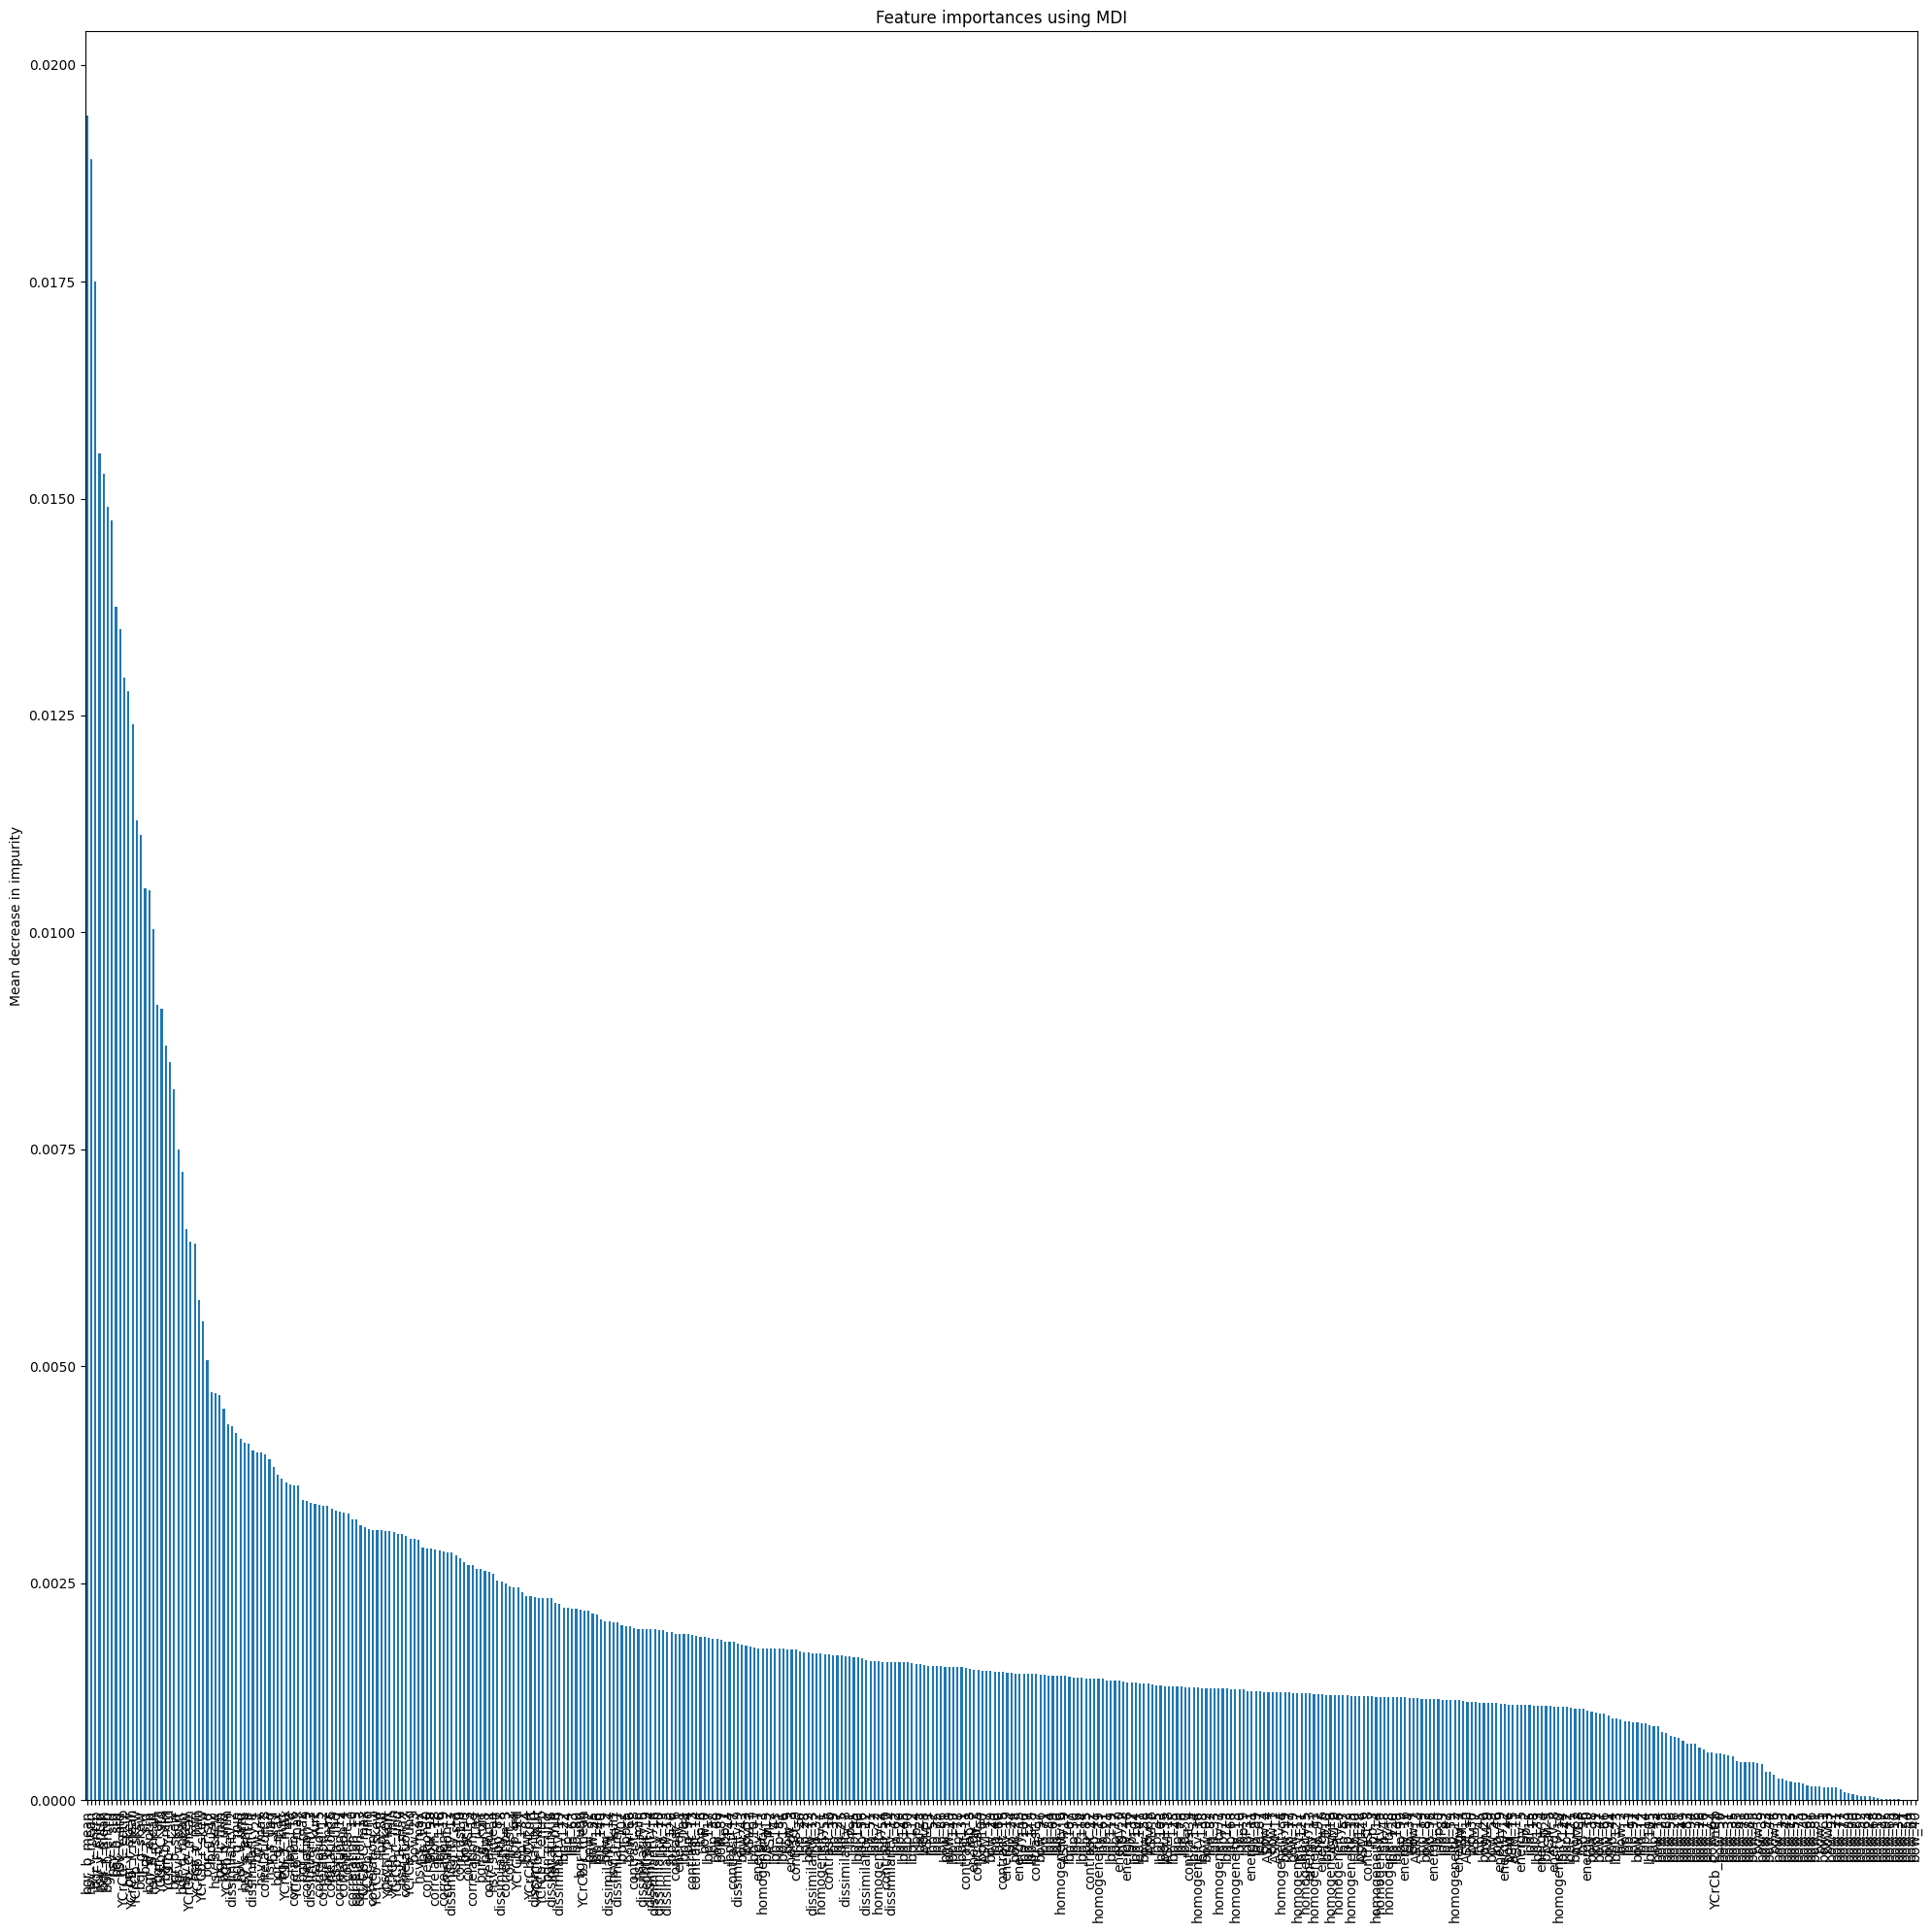

In [56]:
fi_res = pd.concat(feature_importances, axis=1).mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 20))
fi_res.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Text(0, 0.5, 'Percentage of features from top 20%')

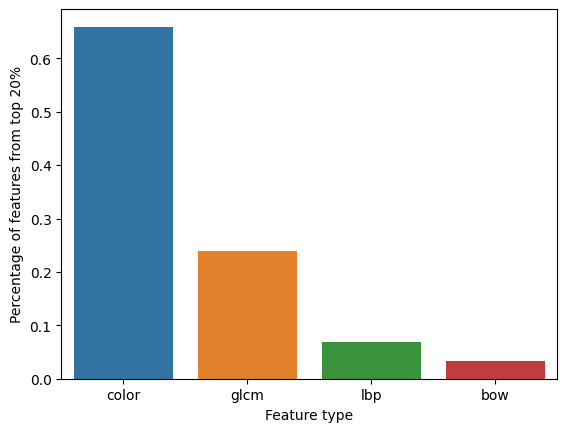

In [57]:
feature_importances_groupped = {k:0 for k in feature_classes.keys()}
feature_classes_inverted = {v:k for k,vv in feature_classes.items() for v in vv}

for fet, count in Counter(fi_res.index[:int(len(fi_res)*0.2)]).items():
    feature_importances_groupped[feature_classes_inverted[fet]] += count
# normalize
feature_importances_groupped = {k:v/sum(feature_importances_groupped.values()) for k,v in feature_importances_groupped.items()}
sns.barplot(x=list(feature_importances_groupped.keys()), y=list(feature_importances_groupped.values()))
plt.xlabel('Feature type')
plt.ylabel('Percentage of features from top 20%')

In [58]:
top_features = fi_res.index[:int(len(fi_res)*0.2)]

X_train = merged_df_train.drop(columns=['class'])[top_features]
X_test = merged_df_val.drop(columns=['class'])[top_features]
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(5082, 88) (1270, 88)
[[449  38  11]
 [ 54 619   5]
 [ 34  21  39]]
Balanced accuracy 0.8435506331223467
Balanced accuracy 0.7431597979188455
Train kappa 0.8761644855650329
Validation kappa 0.7649269832617929


In [59]:
top_features

Index(['bgr_b_mean', 'hsv_v_mean', 'bgr_r_entrp', 'hsv_v_entrp', 'bgr_r_mean',
       'bgr_b_entrp', 'hsv_s_std', 'bgr_b_std', 'hsv_v_std', 'YCrCb_Y_entrp',
       'bgr_r_skew', 'YCrCb_Y_mean', 'YCrCb_Y_skew', 'bgr_g_skew', 'bgr_r_std',
       'bgr_g_entrp', 'hsv_h_mean', 'bgr_b_kurt', 'YCrCb_C_std', 'bgr_b_min',
       'YCrCb_Y_std', 'bgr_b_skew', 'hsv_v_kurt', 'bgr_g_mean', 'hsv_v_skew',
       'YCrCb_C_mean', 'hsv_v_min', 'YCrCb_C_min', 'YCrCb_r_skew', 'bgr_g_std',
       'lbp_142', 'hsv_s_skew', 'bgr_r_min', 'bgr_b_unq', 'YCrCb_Y_min',
       'dissimilarity_2', 'bgr_g_min', 'hsv_v_unq', 'hsv_s_entrp',
       'hsv_h_entrp', 'dissimilarity_1', 'bow_22', 'hsv_v_max',
       'correlation_8', 'hsv_s_unq', 'lbp_147', 'bgr_g_max', 'bgr_r_kurt',
       'YCrCb_Y_max', 'lbp_148', 'correlation_16', 'YCrCb_r_max', 'bgr_r_max',
       'correlation_9', 'dissimilarity_3', 'hsv_s_kurt', 'correlation_5',
       'correlation_12', 'bgr_b_max', 'correlation_6', 'hsv_h_unq',
       'correlation_17', 'c

### PCA

In [10]:
comp = [5, 10, 20, 40, 60, 80, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 230, 250, 270, 300, 330, 350]

test_kappa = []
train_kappa = []
var_expl = []
for c in tqdm(comp):
    pca = PCA(n_components=c)


    X_train = merged_df_train.drop(columns=['class'])
    X_test = merged_df_val.drop(columns=['class'])



    y_train = merged_df_train['class']
    y_test = merged_df_val['class']

    scaler = DescriptorsTransformer(None)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply PCA
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)


    # print(X_train.shape, X_test.shape)

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_pred_train = svc.predict(X_train)

    # print(confusion_matrix(merged_df_val['class'], y_pred))
    # print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
    # print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
    # print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
    # print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))
    test_kappa.append(cohen_kappa_score(merged_df_val['class'], y_pred))
    train_kappa.append(cohen_kappa_score(merged_df_train['class'], y_pred_train))
    var_expl.append(pca.explained_variance_ratio_.sum())


100%|██████████| 23/23 [00:12<00:00,  1.92it/s]


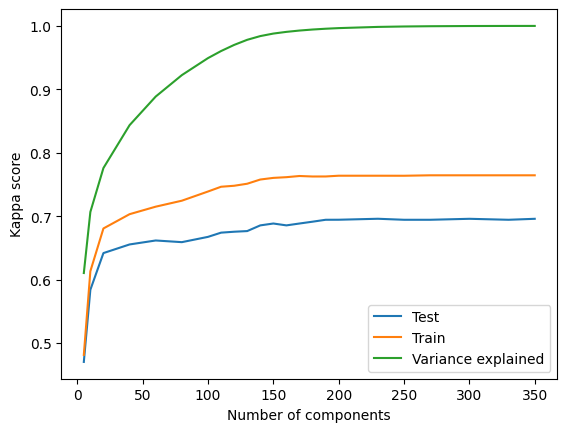

In [11]:
plt.plot(comp, test_kappa)
plt.plot(comp, train_kappa)
plt.plot(comp, var_expl)
plt.xlabel('Number of components')
plt.ylabel('Kappa score')
plt.legend(['Test', 'Train', 'Variance explained'])
plt.show()


In [12]:


X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])



y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


print(X_train_pca.shape, X_test_pca.shape)

svc.fit(X_train_pca, y_train)
y_pred = svc.predict(X_test_pca)
y_pred_train = svc.predict(X_train_pca)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy',balanced_accuracy_score(merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(5082, 150) (1270, 150)
[[447  49   2]
 [ 76 601   1]
 [ 58  26  10]]
Balanced accuracy 0.6684986018259419
Balanced accuracy 0.6301346728784213
Train kappa 0.760338069121899
Validation kappa 0.6883839576302181


### SMOTE

In [74]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import fbeta_score, make_scorer

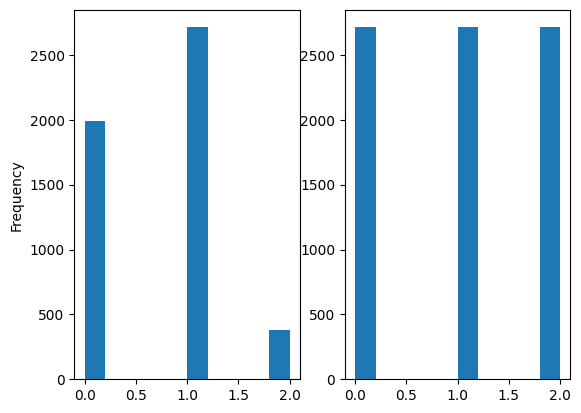

In [14]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
plt.subplot(1,2,1)
merged_df_train['class'].plot.hist()
# plt.show()
plt.subplot(1,2,2)
plt.hist(y_res)
plt.show()

In [15]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])



y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority') 
X_train, y_train = sm.fit_resample(X_train, y_train)


print(X_train.shape, X_test.shape)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced train accuracy',balanced_accuracy_score(y_train, y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(merged_df_val['class'], y_pred))
print('Train kappa',cohen_kappa_score(y_train, y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))

(8139, 442) (1270, 442)
[[420  39  39]
 [ 70 576  32]
 [ 21  15  58]]
Balanced train accuracy 0.9340213785477331
Balanced accuracy 0.7699840975651807
Train kappa 0.9010320678215997
Validation kappa 0.7015522936258916


## Grid Search

In [39]:
scoring = 'kappa'

gs_results = {'rf_fs':dict(), 'pca':dict(), 'smote':dict(), 'full':dict()}

models = {'svc':{'model':SVC(),
                 'param_dict':{'kernel':['rbf'],
                               'C':[1, 10, 0.1, 20, 100, 1000],
                               'class_weight':['balanced', None],
                               'gamma':[0.1, 1, 10, 100]}},
          
          
          'rf':{'model':RandomForestClassifier(),
                 'param_dict':{'bootstrap': [True, False],
                               'max_depth': [10, 20, 40, 80, 100, None]}}}
          
for data_prepr in gs_results.keys():
    
    # load data
    X_train = merged_df_train.drop(columns=['class'])
    X_test = merged_df_val.drop(columns=['class'])
    y_train = merged_df_train['class']
    y_test = merged_df_val['class']

    scaler = DescriptorsTransformer(None)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Apply data preprocessing
    
    if data_prepr == 'pca':
        # Apply PCA
        pca = PCA(n_components=150)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
    
    elif data_prepr == 'smote':
        sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority') 
        X_train, y_train = sm.fit_resample(X_train, y_train)
        
    elif data_prepr == 'rf_fs':
        
        top_features = fi_res.index[:int(len(fi_res)*0.2)]

        X_train = merged_df_train.drop(columns=['class'])[top_features]
        X_test = merged_df_val.drop(columns=['class'])[top_features]
        y_train = merged_df_train['class']
        y_test = merged_df_val['class']

        scaler = DescriptorsTransformer(None)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    if scoring == 'kappa':
        scoring = make_scorer(cohen_kappa_score)
    for model, mpar in models.items():
        clf = GridSearchCV(mpar['model'],
                           mpar['param_dict'],
                           scoring=scoring, 
                           cv=5, n_jobs=-1,
                           verbose = 0)
        clf.fit(X_train, y_train)
        
        best_est = clf.best_estimator_
        best_est.fit(X_train, y_train)
        y_pred = best_est.predict(X_test)
        y_pred_train = best_est.predict(X_train)     
        
        gs_results[data_prepr][model] = dict()
        gs_results[data_prepr][model]['metric'] = 'kappa'
        gs_results[data_prepr][model]['gridsearch'] = clf
        gs_results[data_prepr][model]['best_estimator_'] = clf.best_estimator_
        gs_results[data_prepr][model]['best_score_'] = clf.best_score_
        gs_results[data_prepr][model]['best_params_'] = clf.best_params_
        gs_results[data_prepr][model]['best_estimator_'] = clf.best_estimator_
        
        gs_results[data_prepr][model]['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        gs_results[data_prepr][model]['train_balanced_accuracy_score'] = balanced_accuracy_score(y_train, y_pred_train)
        gs_results[data_prepr][model]['test_balanced_accuracy_score'] = balanced_accuracy_score(y_test, y_pred)
        gs_results[data_prepr][model]['train_cohen_kappa_score'] = cohen_kappa_score(y_train, y_pred_train)
        gs_results[data_prepr][model]['test_cohen_kappa_score'] = cohen_kappa_score(y_test, y_pred)

/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [36]:
gs_results = dict()
gs_results_kappa = {'svc':pd.read_pickle('gs_results_kappa_svc.pkl'),
                    'rf':pd.read_pickle('gs_results_kappa_rf.pkl')}

gs_results_balacc = {'svc':pd.read_pickle('gs_results_balacc_svc.pkl'),
                    'rf':pd.read_pickle('gs_results_balacc_rf.pkl')}

In [37]:
flattened_kappa_res = []

for est in gs_results_kappa.keys():
    for data in gs_results_kappa[est].keys():
        r = {k:v for k,v in gs_results_kappa[est][data][est].items()}
        r['estimator_class'] = est
        r['data'] = data
        flattened_kappa_res.append(r)

kappa_res_df = pd.DataFrame(flattened_kappa_res)
kappa_res_df = kappa_res_df.sort_values(by=['test_cohen_kappa_score'])
kappa_res_df

,metric,gridsearch,best_estimator_,best_score_,best_params_,confusion_matrix,train_balanced_accuracy_score,test_balanced_accuracy_score,train_cohen_kappa_score,test_cohen_kappa_score,estimator_class,data
3,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.025460,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[17, 481, 0], [0, 678, 0], [0, 93, 1]]",1.0,0.348258,1.0,0.035082,svc,full
1,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.038848,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[24, 474, 0], [0, 678, 0], [0, 92, 2]]",1.0,0.356490,1.0,0.050847,svc,pca
2,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.641735,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[27, 471, 0], [0, 678, 0], [0, 91, 3]]",1.0,0.362044,1.0,0.058952,svc,smote
5,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=40, max_feat...",0.615428,"{'bootstrap': False, 'max_depth': 40}","[[401, 96, 1], [76, 602, 0], [52, 33, 9]]",1.0,0.596290,1.0,0.615828,rf,pca
0,kappa,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.660593,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[410, 82, 6], [39, 638, 1], [34, 34, 26]]",1.0,0.680297,1.0,0.709901,svc,rf_fs
4,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=20, max_feat...",0.698690,"{'bootstrap': False, 'max_depth': 20}","[[432, 61, 5], [52, 625, 1], [45, 30, 19]]",1.0,0.663809,1.0,0.714064,rf,rf_fs
7,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=20, max_feat...",0.694142,"{'bootstrap': False, 'max_depth': 20}","[[434, 61, 3], [49, 627, 2], [47, 26, 21]]",1.0,0.673223,1.0,0.723152,rf,full
6,kappa,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=80, max_feat...",0.888688,"{'bootstrap': False, 'max_depth': 80}","[[427, 54, 17], [64, 604, 10], [28, 19, 47]]",1.0,0.749428,1.0,0.725553,rf,smote


In [38]:
flattened_balacc_res = []

for est in gs_results_balacc.keys():
    for data in gs_results_balacc[est].keys():
        r = {k:v for k,v in gs_results_balacc[est][data][est].items()}
        r['estimator_class'] = est
        r['data'] = data
        flattened_balacc_res.append(r)

balacc_res_df = pd.DataFrame(flattened_balacc_res)
balacc_res_df= balacc_res_df.sort_values(by=['test_cohen_kappa_score'])
balacc_res_df

,metric,gridsearch,best_estimator_,best_score_,best_params_,confusion_matrix,train_balanced_accuracy_score,test_balanced_accuracy_score,train_cohen_kappa_score,test_cohen_kappa_score,estimator_class,data
3,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.342197,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[17, 481, 0], [0, 678, 0], [0, 93, 1]]",1.0,0.348258,1.0,0.035082,svc,full
1,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.346881,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[24, 474, 0], [0, 678, 0], [0, 92, 2]]",1.0,0.356490,1.0,0.050847,svc,pca
2,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.761124,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[27, 471, 0], [0, 678, 0], [0, 91, 3]]",1.0,0.362044,1.0,0.058952,svc,smote
5,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=40, max_feat...",0.580964,"{'bootstrap': False, 'max_depth': 40}","[[408, 90, 0], [81, 597, 0], [44, 39, 11]]",1.0,0.605610,1.0,0.622362,rf,pca
0,balanced_accuracy,"GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,...","SVC(C=10, class_weight='balanced', gamma=0.1)",0.630521,"{'C': 10, 'class_weight': 'balanced', 'gamma':...","[[410, 82, 6], [39, 638, 1], [34, 34, 26]]",1.0,0.680297,1.0,0.709901,svc,rf_fs
4,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=80, max_feat...",0.648579,"{'bootstrap': False, 'max_depth': 80}","[[430, 62, 6], [53, 623, 2], [46, 27, 21]]",1.0,0.668579,1.0,0.711897,rf,rf_fs
7,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=80, max_feat...",0.636460,"{'bootstrap': False, 'max_depth': 80}","[[433, 60, 5], [51, 626, 1], [46, 26, 22]]",1.0,0.675608,1.0,0.722056,rf,full
6,balanced_accuracy,"GridSearchCV(cv=5, estimator=RandomForestClass...","(DecisionTreeClassifier(max_depth=40, max_feat...",0.926395,"{'bootstrap': False, 'max_depth': 40}","[[428, 52, 18], [62, 607, 9], [25, 21, 48]]",1.0,0.755119,1.0,0.732659,rf,smote


In [35]:
kappa_res_df.iloc[7]

metric                                                                       kappa
gridsearch                       GridSearchCV(cv=5, estimator=RandomForestClass...
best_estimator_                  (DecisionTreeClassifier(max_depth=80, max_feat...
best_score_                                                               0.888688
best_params_                                 {'bootstrap': False, 'max_depth': 80}
confusion_matrix                      [[427, 54, 17], [64, 604, 10], [28, 19, 47]]
train_balanced_accuracy_score                                                  1.0
test_balanced_accuracy_score                                              0.749428
train_cohen_kappa_score                                                        1.0
test_cohen_kappa_score                                                    0.725553
estimator_class                                                                 rf
data                                                                         smote
Name

Best classifiers:
* RandomForestClassifier(bootstrap=False, max_depth=40) -> full, test_cohen_kappa_score                                                    0.709901

```
[[428, 52, 18]
[62, 607, 9]
[25, 21, 48]]
```

* SVC(C=10, class_weight='balanced', gamma=0.1) -> rf_fs test_cohen_kappa_score                                                    0.732659

```
 [[410, 82, 6]
 [39, 638, 1]
 [34, 34, 26]]
 ```

 * RandomForestClassifier(bootstrap=False, max_depth=80) -> smote + full, test_cohen_kappa_score                                                    0.725553

```
 [[427, 54, 17]
 [64, 604, 10]
 [28, 19, 47]]
```

* SVC(kernel='rbf', C=8, random_state=42, probability=False, class_weight='balanced') -> full -> 76 kappa

### Ensembling

In [225]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import mode

In [221]:
classifiers = [(SVC(kernel='rbf', C=8, probability=True, class_weight='balanced'), 'full', 'svc_full'),
               (RandomForestClassifier(bootstrap=False, max_depth=80), 'smote', 'rf_smote'),
               (SVC(C=10, class_weight='balanced', gamma=0.1, probability=True), 'rf_fs', 'svc_rf_fs'),
               (RandomForestClassifier(bootstrap=False, max_depth=40), 'pca', 'rf_pca')]


TOP_FEATURES = ['bgr_b_mean', 'hsv_v_mean', 'bgr_r_entrp', 'hsv_v_entrp', 'bgr_r_mean',
                'bgr_b_entrp', 'hsv_s_std', 'bgr_b_std', 'hsv_v_std', 'YCrCb_Y_entrp',
                'bgr_r_skew', 'YCrCb_Y_mean', 'YCrCb_Y_skew', 'bgr_g_skew', 'bgr_r_std',
                'bgr_g_entrp', 'hsv_h_mean', 'bgr_b_kurt', 'YCrCb_C_std', 'bgr_b_min',
                'YCrCb_Y_std', 'bgr_b_skew', 'hsv_v_kurt', 'bgr_g_mean', 'hsv_v_skew',
                'YCrCb_C_mean', 'hsv_v_min', 'YCrCb_C_min', 'YCrCb_r_skew', 'bgr_g_std',
                'lbp_142', 'hsv_s_skew', 'bgr_r_min', 'bgr_b_unq', 'YCrCb_Y_min',
                'dissimilarity_2', 'bgr_g_min', 'hsv_v_unq', 'hsv_s_entrp',
                'hsv_h_entrp', 'dissimilarity_1', 'bow_22', 'hsv_v_max',
                'correlation_8', 'hsv_s_unq', 'lbp_147', 'bgr_g_max', 'bgr_r_kurt',
                'YCrCb_Y_max', 'lbp_148', 'correlation_16', 'YCrCb_r_max', 'bgr_r_max',
                'correlation_9', 'dissimilarity_3', 'hsv_s_kurt', 'correlation_5',
                'correlation_12', 'bgr_b_max', 'correlation_6', 'hsv_h_unq',
                'correlation_17', 'correlation_4', 'contrast_1', 'correlation_10',
                'correlation_15', 'correlation_13', 'YCrCb_C_max', 'YCrCb_r_unq',
                'correlation_11', 'YCrCb_C_skew', 'lbp_88', 'hsv_h_skew',
                'YCrCb_Y_kurt', 'YCrCb_r_min', 'YCrCb_C_unq', 'hsv_h_max',
                'correlation_7', 'YCrCb_Y_unq', 'bow_23', 'hsv_s_max', 'lbp_132',
                'correlation_0', 'bow_98', 'correlation_18', 'lbp_116',
                'correlation_19', 'correlation_2']

class EnsemblingClssfifier:
    def __init__(self, class_data:list, ensembling=None) -> None:
        self.class_data = class_data
        self.model_names = [x[2] for x in class_data]
        self.smote = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority')
        self.tf_fs_set = TOP_FEATURES
        self.transformer = DescriptorsTransformer(None)
        self.pca = PCA(n_components=0.95)
        self.ensembling = ensembling
        
    def fit(self, X, y, columns_X):
        """X - raw 442 shape array with features
        columngs_X - list of columns names used to make X
        only once pca per class  data"""
        # normalize data
        X = self.transformer.fit_transform(X)
        
        for model, dataset, name in self.class_data:
            if dataset == 'full':
                model.fit(X, y)
            elif dataset == 'smote':
                X_smote, y_smote = self.smote.fit_resample(X, y)
                model.fit(X_smote, y_smote)
            elif dataset == 'rf_fs':
                X_rf = X[:,np.isin(columns_X, self.tf_fs_set)]
                model.fit(X_rf, y)           
            elif dataset == 'pca':
                X_pca = self.pca.fit_transform(X)
                model.fit(X_pca, y)
            else:
                raise ValueError('Unknown dataset')
        
        if 'stacking' in self.ensembling:
            self.meta_model = LogisticRegression()
            predictions, predicitons_proba = self.predict(X, columns_X, False)
            predictions = {k:v for k,v in predictions.items() if k in self.model_names}
            predicitons_proba = {k:v for k,v in predicitons_proba.items() if k in self.model_names}
            self.meta_model.fit(np.hstack(predicitons_proba.values()), y)
        
    def predict(self, X, columns_X, with_meta=True):
        X = self.transformer.fit_transform(X)
        
        predictions = dict()
        predicitons_proba = dict()
        
        for model, dataset, name in self.class_data:
            if dataset == 'full':
                predictions[name] = model.predict(X)
                predicitons_proba[name] = model.predict_proba(X)

            elif dataset == 'smote':
                predictions[name] = model.predict(X)
                predicitons_proba[name] = model.predict_proba(X)
            
            elif dataset == 'rf_fs':
                X_rf = X[:,np.isin(columns_X, self.tf_fs_set)]
                predictions[name] = model.predict(X_rf)
                predicitons_proba[name] = model.predict_proba(X_rf)
            elif dataset == 'pca':
                X_pca = self.pca.transform(X)
                predictions[name] = model.predict(X_pca)
                predicitons_proba[name] = model.predict_proba(X_pca)
            else:
                raise ValueError('Unknown dataset')
        
        if 'stacking' in self.ensembling and with_meta:
            predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
            predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))
            
        if 'hard_voting' in self.ensembling:
            predictions['hard_voting'] = mode(np.stack([v for k,v in predictions.items() if k in self.model_names]), axis=0)[0][0]
            predicitons_proba['hard_voting'] = None
            
        if 'soft_voting' in self.ensembling:
            predicitons_proba['soft_voting'] = np.asarray([v for k, v in predicitons_proba.items() if k in self.model_names]).mean(axis=0)
            predictions['soft_voting'] = predicitons_proba['soft_voting'].argmax(axis=1)
            
        return predictions, predicitons_proba
    
    def evaluate(self, X, y, columns_X, plot=True):
        predictions, predicitons_proba = self.predict(X, columns_X)
        kappa_scores = {name: cohen_kappa_score(y, pred) for name, pred in predictions.items()}
        balacc_scores = {name: balanced_accuracy_score(y, pred) for name, pred in predictions.items()}
        
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(18, 6))

            # plot bar plot of the dict
            sns.barplot(y=list(kappa_scores.values()), x=list(kappa_scores.keys()), ax=axs[0])
            axs[0].set_title('Kappa scores')
            axs[0].bar_label(axs[0].containers[0])

            sns.barplot(y=list(balacc_scores.values()), x=list(balacc_scores.keys()), ax=axs[1])
            axs[1].set_title('Balanced Accuracy scores')
            axs[1].bar_label(axs[1].containers[0])


            plt.show()
        return kappa_scores, balacc_scores

In [222]:
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')


X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']

In [223]:
ens = EnsemblingClssfifier(classifiers, ['soft_voting', 'stacking', 'hard_voting'])

ens.fit(X_train.values, y_train.values, X_train.columns)


/tmp/ipykernel_26546/420270201.py:65: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.meta_model.fit(np.hstack(predicitons_proba.values()), y)


In [226]:
predictions, predicitons_proba = ens.predict(X_test.values, X_test.columns)

/tmp/ipykernel_26546/420270201.py:94: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_26546/420270201.py:95: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))


/tmp/ipykernel_26546/420270201.py:94: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_26546/420270201.py:95: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))


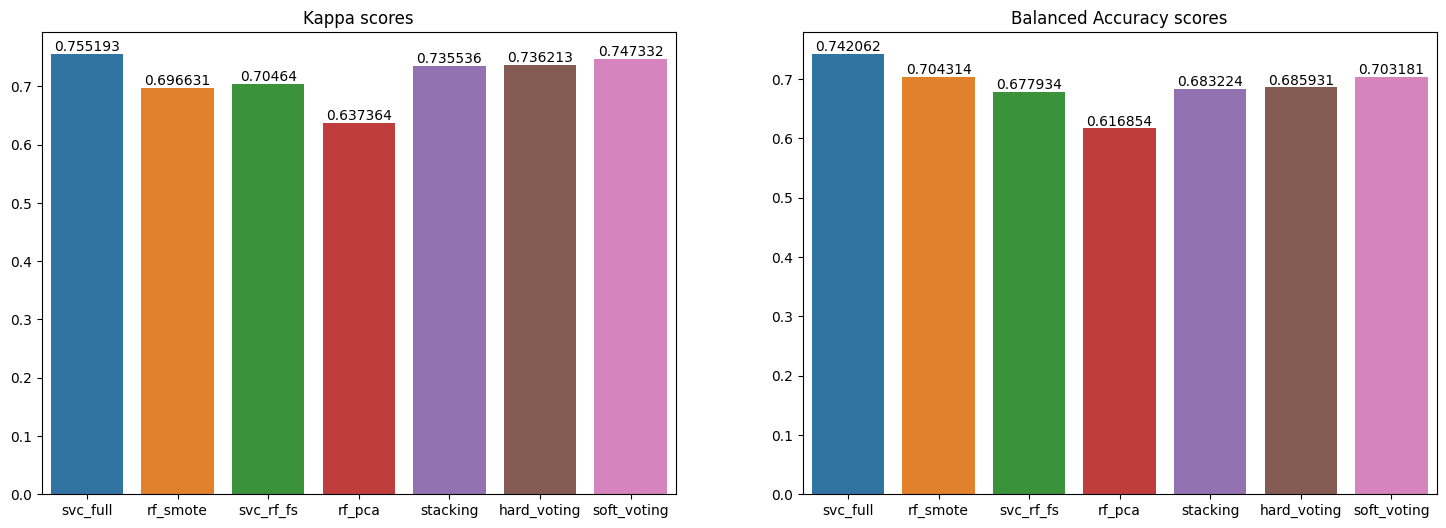

In [224]:
kappa_scores, balacc_scores = ens.evaluate(X_test.values, y_test.values, X_test.columns)

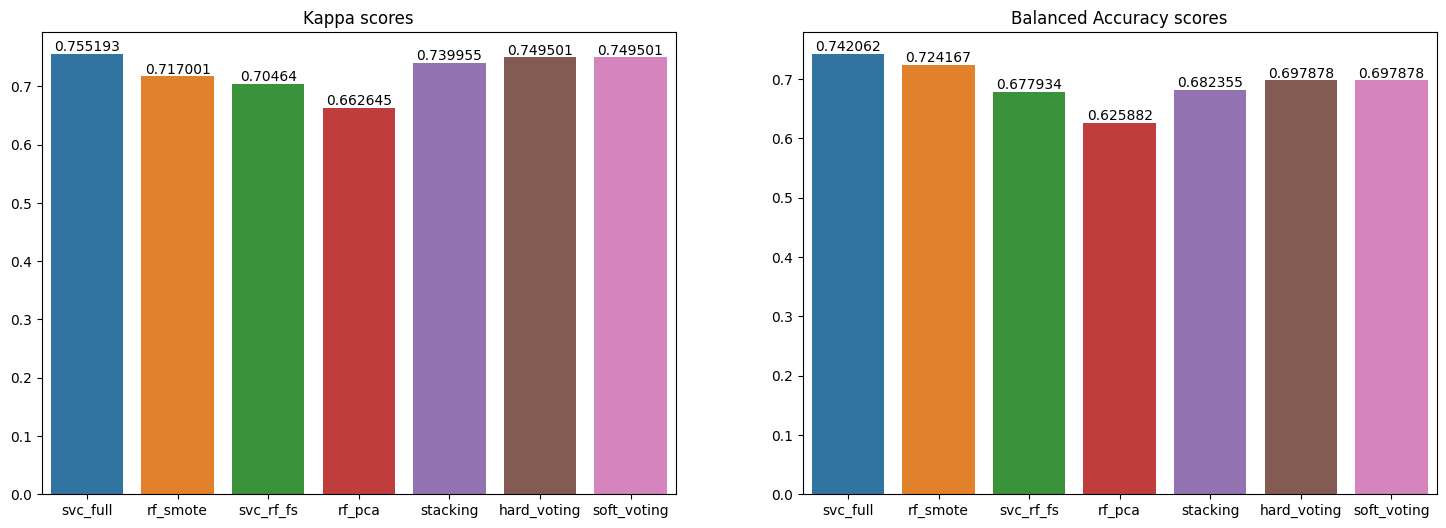

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# plot bar plot of the dict
sns.barplot(y=list(kappa_scores.values()), x=list(kappa_scores.keys()), ax=axs[0])
axs[0].set_title('Kappa scores')
axs[0].bar_label(axs[0].containers[0])

sns.barplot(y=list(balacc_scores.values()), x=list(balacc_scores.keys()), ax=axs[1])
axs[1].set_title('Balanced Accuracy scores')
axs[1].bar_label(axs[1].containers[0])


plt.show()

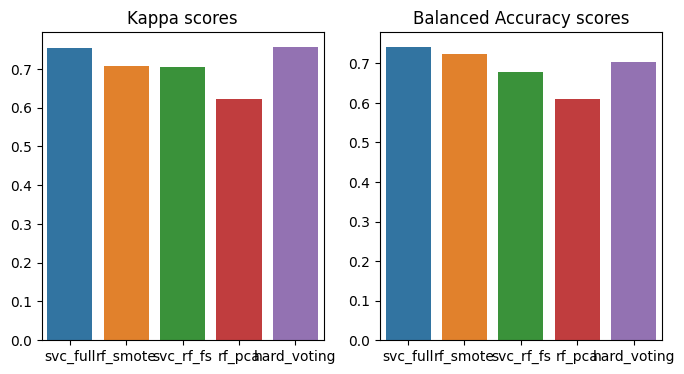

In [143]:
kappa_scores, balacc_scores = ens.evaluate(X_test.values, y_test.values, X_test.columns)

/tmp/ipykernel_26546/2742990562.py:91: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_26546/2742990562.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))


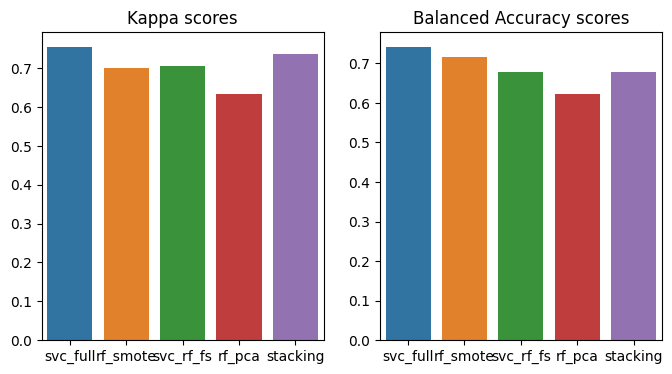

In [139]:
kappa_scores, balacc_scores = ens.evaluate(X_test.values, y_test.values, X_test.columns)

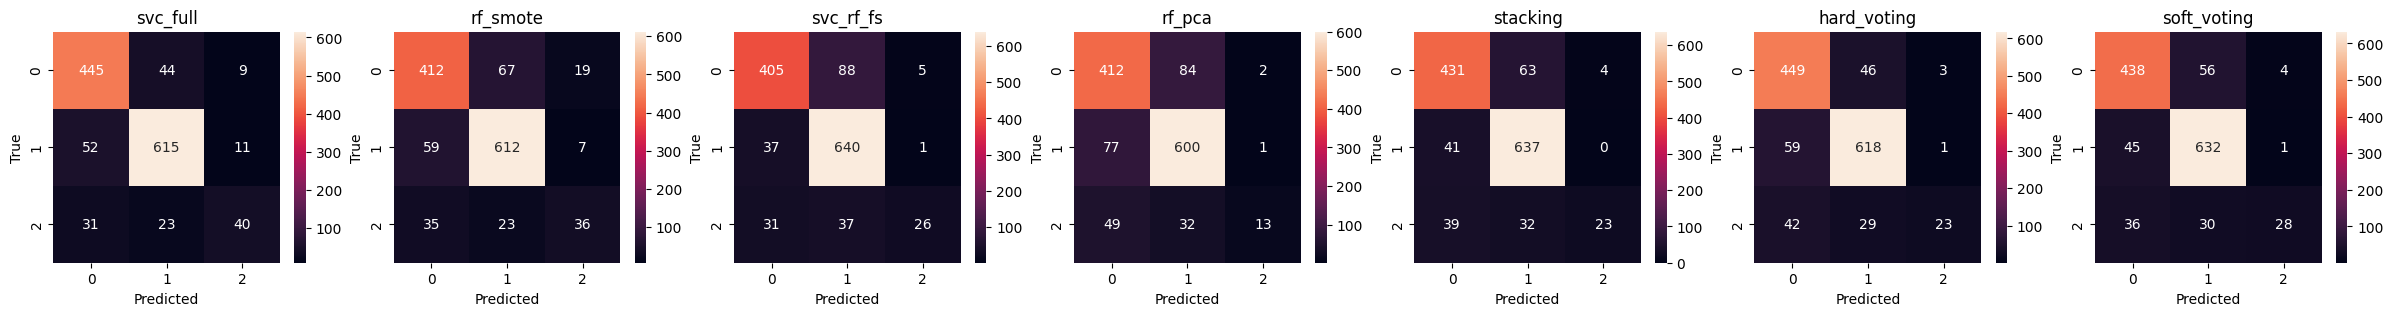

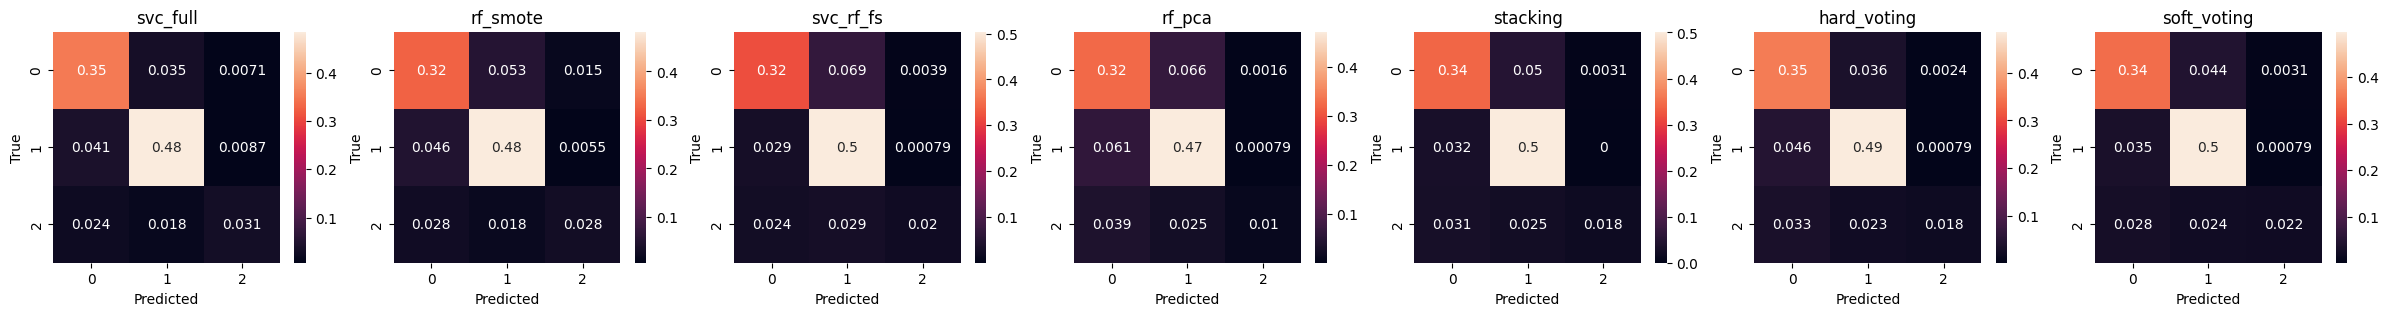

In [239]:
fig, axs = plt.subplots(1, len(predictions), figsize=(30, 3))

for i, (name, pred) in enumerate(predictions.items()):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(name)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    
plt.show()

fig, axs = plt.subplots(1, len(predictions), figsize=(30, 3))

for i, (name, pred) in enumerate(predictions.items()):
    sns.heatmap(confusion_matrix(y_test, pred, normalize='all'), annot=True, ax=axs[i], )
    axs[i].set_title(name)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    
plt.show()

In [229]:
predictions

{'svc_full': array([1, 1, 1, ..., 0, 0, 1]),
 'rf_smote': array([1, 1, 1, ..., 0, 0, 0]),
 'svc_rf_fs': array([1, 1, 1, ..., 1, 0, 1]),
 'rf_pca': array([1, 1, 1, ..., 0, 0, 1]),
 'stacking': array([1, 1, 1, ..., 1, 0, 1]),
 'hard_voting': array([1, 1, 1, ..., 0, 0, 1]),
 'soft_voting': array([1, 1, 1, ..., 1, 0, 1])}

In [88]:
predictions, predicitons_proba = ens.predict(X_test.values, X_test.columns)

In [85]:
for pred in predictions:
    print(pred, cohen_kappa_score(y_test, predictions[pred]))

svc_full 0.7551932148040639
rf_smote 0.7056129717994528
svc_rf_fs 0.7125781138140788
rf_pca 0.6711183987334615


In [63]:
len(TOP_FEATURES)

88

In [ ]:
rfmodel = RandomForestClassifier(n_estimators=200,
                               max_depth=20,
                               class_weight='balanced',
                               n_jobs=-1)
svcmodel = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')

In [ ]:
vc = VotingClassifier(estimators=[('rf', RandomForestClassifier(),
                                   'svc',
                                   )], voting='soft', n_jobs=-1)

In [68]:
merged_df_train.values[:,np.isin(merged_df_train.columns, TOP_FEATURES)].shape

(5082, 88)

In [241]:
merged_df_train['class']

name
mel02171_inpaint_0_5.png    1
mel01400_inpaint_0_5.png    1
mel00176_inpaint_0_5.png    1
mel02216_inpaint_0_5.png    1
mel00728_inpaint_0_5.png    1
                           ..
scc00027_inpaint_0_5.png    2
scc00376_inpaint_0_5.png    2
scc00239_inpaint_0_5.png    2
scc00130_inpaint_0_5.png    2
scc00149_inpaint_0_5.png    2
Name: class, Length: 5082, dtype: int64